## **0. Tải bộ dữ liệu**
```python
from google.colab import drive

drive.mount('/content/drive')
!cp /path/to/dataset/on/your/drive .
```

## **1. Import các thư viện cần thiết**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

RANDOM_SEED = 1234
tf.random.set_seed(RANDOM_SEED)

## **2. Trực quan hóa dữ liệu**

In [ ]:
filepath = '/source/Data/Sentiment Data/all_labeled.csv'
sentiment = pd.read_csv(filepath)
sentiment = sentiment.drop(['Unnamed: 0'], axis=1)
sentiment['Time'] = pd.to_datetime(sentiment['Time'], format='%Y-%m-%d') + pd.Timedelta(days=1)
sentiment

,Time,Negative,Neutral,Positive
0,2007-01-12,2.551659,-1.139742,-0.954618
1,2007-10-04,-0.538300,-0.326551,1.388634
2,2007-10-17,-1.775271,-0.143663,1.263513
3,2007-10-19,-1.334227,2.070566,-1.097317
4,2007-10-20,1.956473,0.092072,-1.421773
...,...,...,...,...
6095,2024-06-27,0.721511,-0.198750,0.035989
6096,2024-06-28,0.764717,0.711633,-1.125684
6097,2024-06-29,2.665487,-0.449808,-1.541188
6098,2024-06-30,2.665604,-0.213700,-1.765478


In [ ]:
filepath = '/source/Data/Sentiment Data/Data - HNX30.csv'
stock = pd.read_csv(filepath)
stock['Time'] = pd.to_datetime(stock['Time'], format='%d/%m/%Y')
stock

,Time,Last,Open,High,Low,Volume,Exchange Rate,CPI,GDP,Interest,Dow Jones,Hang Seng,Gold Price,Oil Price
0,2024-06-28,516.11,524.67,512.94,515.71,42664881,"25,445.00",0.17,"2,727,565.00",2.885,"39,118.86","17,718.61","2,350.9",81.54
1,2024-06-28,516.11,524.67,512.94,515.71,42664881,"25,445.00",0.17,"2,727,565.00",2.885,"39,118.86","17,718.61","2,350.9",81.54
2,2024-06-27,518.06,523.91,513.89,523.74,30990800,"25,455.00",0.17,"2,727,565.00",2.889,"39,164.06","17,716.47","2,348.7",81.74
3,2024-06-27,518.06,523.91,513.89,523.74,30990800,"25,455.00",0.17,"2,727,565.00",2.889,"39,164.06","17,716.47","2,348.7",81.74
4,2024-06-26,520.34,524.35,513.42,521.19,30719382,"25,465.00",0.17,"2,727,565.00",2.899,"39,127.80","18,089.93","2,313.2",80.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,2012-07-13,130.90,136.20,130.80,134.53,25541300,"20,850.00",-0.29,"720,208.00",10.073,"12,777.09","19,092.63","1,592.0",87.10
3141,2012-07-12,128.30,131.50,128.10,130.90,15423500,"20,847.50",-0.29,"720,208.00",10.305,"12,573.27","19,025.11","1,565.3",86.08
3142,2012-07-11,126.50,129.10,126.10,128.30,10477000,"20,850.00",-0.29,"720,208.00",10.081,"12,604.53","19,419.87","1,575.7",85.81
3143,2012-07-10,127.30,128.40,126.10,126.50,9686400,"20,845.00",-0.29,"720,208.00",9.875,"12,653.12","19,396.36","1,579.8",83.91


In [ ]:
df = pd.merge(stock, sentiment, on='Time', how = 'left')
#df['Last'] = df['Last'].str.replace(',', '').astype(float)
#df['Open'] = df['Open'].str.replace(',', '').astype(float)
#df['High'] = df['High'].str.replace(',', '').astype(float)
#df['Low'] = df['Low'].str.replace(',', '').astype(float)
df['Volume'] = df['Volume'].astype(int)
df['Exchange Rate'] = df['Exchange Rate'].str.replace(',', '').astype(float)
df['Interest'] = df['Interest'].astype(float)
df['GDP'] = df['GDP'].str.replace(',', '').astype(float)
df['Dow Jones'] = df['Dow Jones'].str.replace(',', '').astype(float)
df['Hang Seng'] = df['Hang Seng'].str.replace(',', '').astype(float)
df['Gold Price'] = df['Gold Price'].str.replace(',', '').astype(float)
df['Oil Price'] = df['Oil Price'].astype(float)
df.set_index('Time', inplace=True)
df

,Last,Open,High,Low,Volume,Exchange Rate,CPI,GDP,Interest,Dow Jones,Hang Seng,Gold Price,Oil Price,Negative,Neutral,Positive
Time,,,,,,,,,,,,,,,,
2024-06-28,516.11,524.67,512.94,515.71,42664881,25445.0,0.17,2727565.0,2.885,39118.86,17718.61,2350.9,81.54,0.764717,0.711633,-1.125684
2024-06-28,516.11,524.67,512.94,515.71,42664881,25445.0,0.17,2727565.0,2.885,39118.86,17718.61,2350.9,81.54,0.764717,0.711633,-1.125684
2024-06-27,518.06,523.91,513.89,523.74,30990800,25455.0,0.17,2727565.0,2.889,39164.06,17716.47,2348.7,81.74,0.721511,-0.198750,0.035989
2024-06-27,518.06,523.91,513.89,523.74,30990800,25455.0,0.17,2727565.0,2.889,39164.06,17716.47,2348.7,81.74,0.721511,-0.198750,0.035989
2024-06-26,520.34,524.35,513.42,521.19,30719382,25465.0,0.17,2727565.0,2.899,39127.80,18089.93,2313.2,80.90,-2.753078,-0.651034,3.315490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-07-13,130.90,136.20,130.80,134.53,25541300,20850.0,-0.29,720208.0,10.073,12777.09,19092.63,1592.0,87.10,1.999580,-0.485120,-1.163107
2012-07-12,128.30,131.50,128.10,130.90,15423500,20847.5,-0.29,720208.0,10.305,12573.27,19025.11,1565.3,86.08,-0.489124,1.089516,-0.362402
2012-07-11,126.50,129.10,126.10,128.30,10477000,20850.0,-0.29,720208.0,10.081,12604.53,19419.87,1575.7,85.81,1.579786,-0.079399,-0.678299


In [ ]:
columns_to_scale = ['Last', 'Open', 'High', 'Low', 'Volume', 'Exchange Rate', 'CPI',
                    'GDP', 'Interest', 'Dow Jones', 'Hang Seng', 'Gold Price', 'Oil Price',
                    'Positive', 'Negative', 'Neutral']

scaler = MaxAbsScaler()

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

df = df.drop(columns=['Open', 'High', 'Low'])

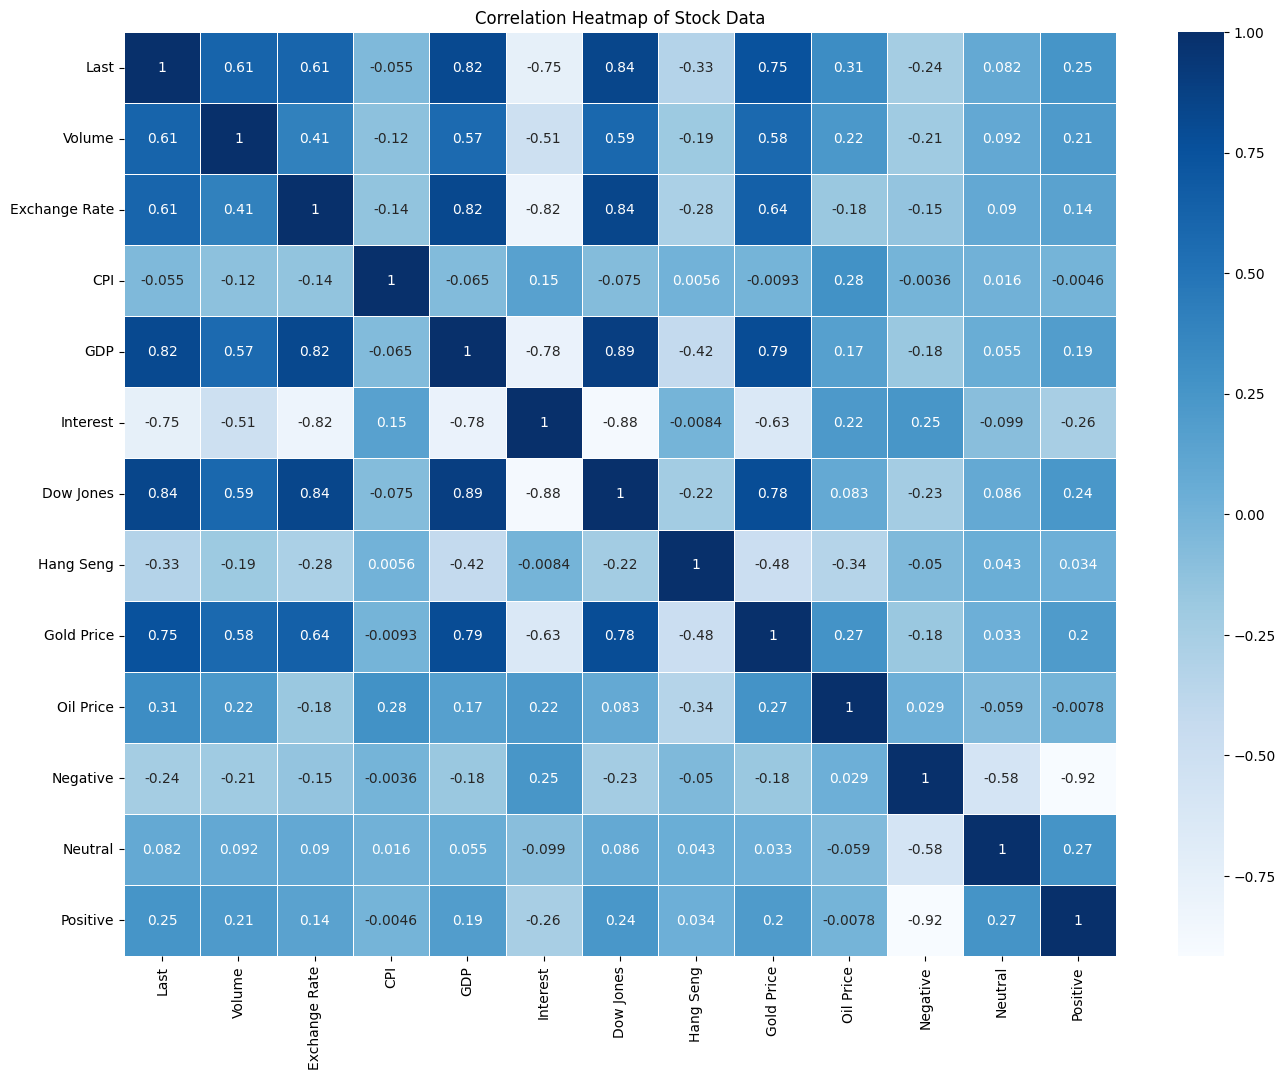

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, cmap='Blues', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Data')
plt.show()


In [ ]:
df.describe()

,Last,Volume,Exchange Rate,CPI,GDP,Interest,Dow Jones,Hang Seng,Gold Price,Oil Price,Negative,Neutral,Positive
count,3145.000000,3145.000000,3144.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000,3145.000000
mean,0.322085,0.232188,0.895971,0.118933,0.554902,0.488369,0.628108,0.704735,0.636543,0.555650,0.199044,0.027259,-0.134825
std,0.199510,0.150104,0.043285,0.201474,0.228341,0.224669,0.197029,0.114587,0.138647,0.170297,0.476584,0.243594,0.362407
min,0.066760,0.000000,0.817661,-0.700000,0.234038,0.194280,0.313531,0.442992,0.428496,-0.304204,-0.981915,-0.533980,-0.729094
25%,0.176644,0.116368,0.875555,0.009091,0.352445,0.277121,0.444041,0.624317,0.518024,0.413015,-0.156795,-0.145951,-0.419512
50%,0.220270,0.192756,0.897346,0.090909,0.473436,0.462917,0.620287,0.699130,0.583833,0.555538,0.297190,-0.013170,-0.235111
75%,0.493707,0.311830,0.915741,0.222727,0.784617,0.657865,0.826314,0.790017,0.749173,0.688036,0.588974,0.165734,0.090611
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3145 entries, 2024-06-28 to 2012-07-09
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Last           3145 non-null   float64
 1   Volume         3145 non-null   float64
 2   Exchange Rate  3144 non-null   float64
 3   CPI            3145 non-null   float64
 4   GDP            3145 non-null   float64
 5   Interest       3145 non-null   float64
 6   Dow Jones      3145 non-null   float64
 7   Hang Seng      3145 non-null   float64
 8   Gold Price     3145 non-null   float64
 9   Oil Price      3145 non-null   float64
 10  Negative       3145 non-null   float64
 11  Neutral        3145 non-null   float64
 12  Positive       3145 non-null   float64
dtypes: float64(13)
memory usage: 344.0 KB


In [ ]:
df = df.rolling(window=5).mean()
df = df.dropna()

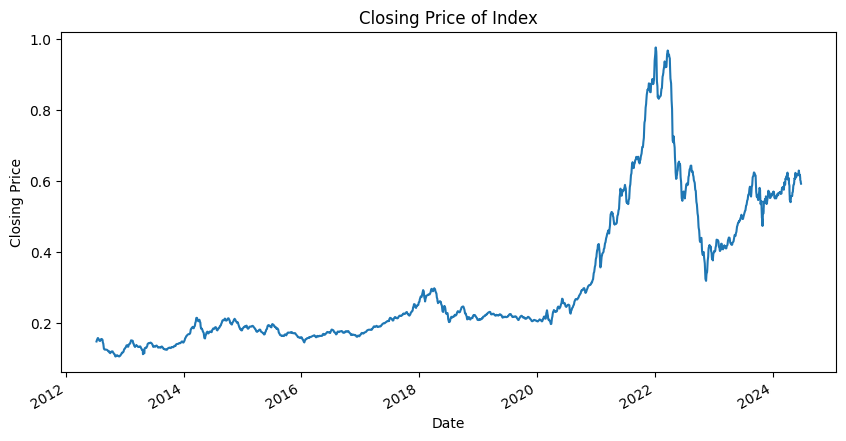

In [ ]:
plt.figure(figsize=(10, 5))
df['Last'].plot()
plt.title('Closing Price of Index')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

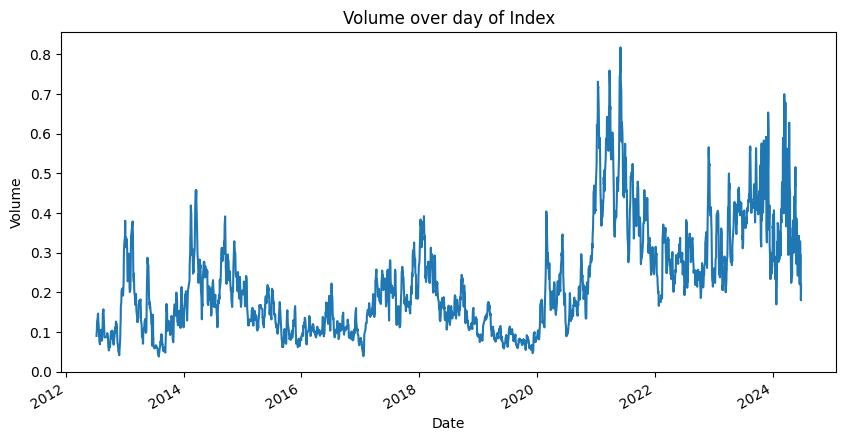

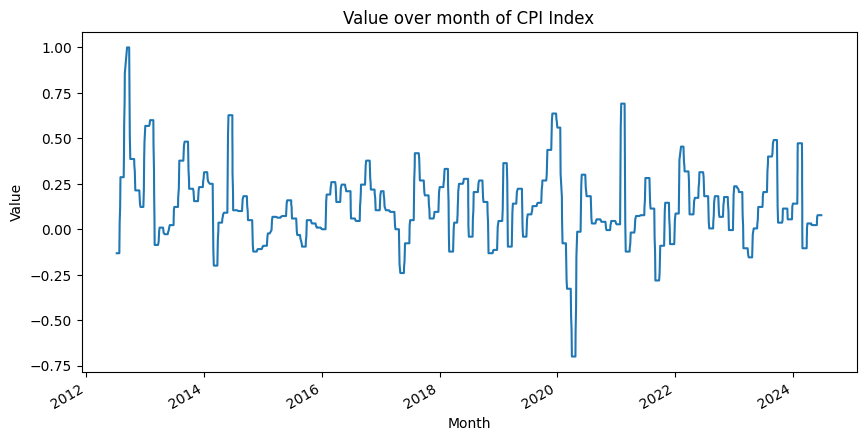

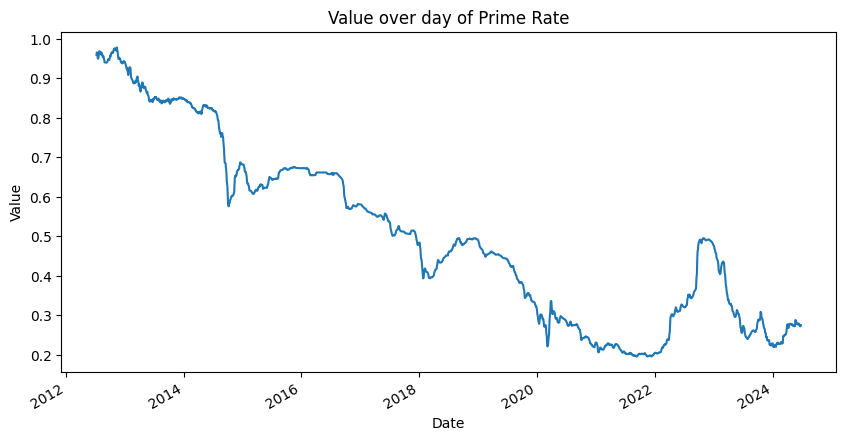

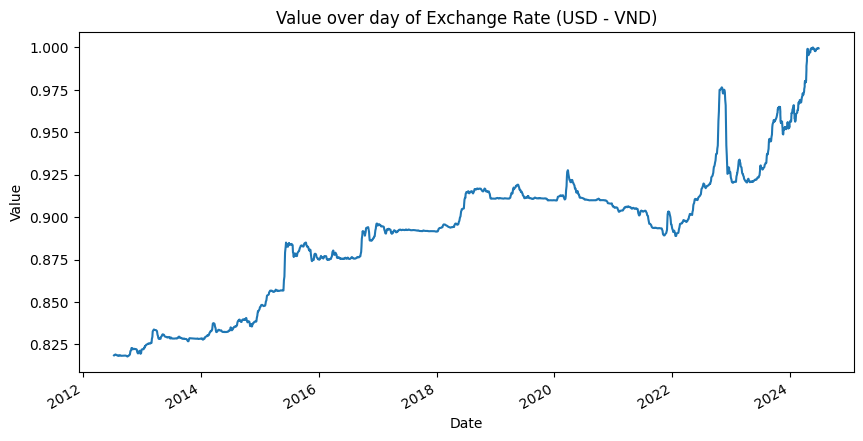

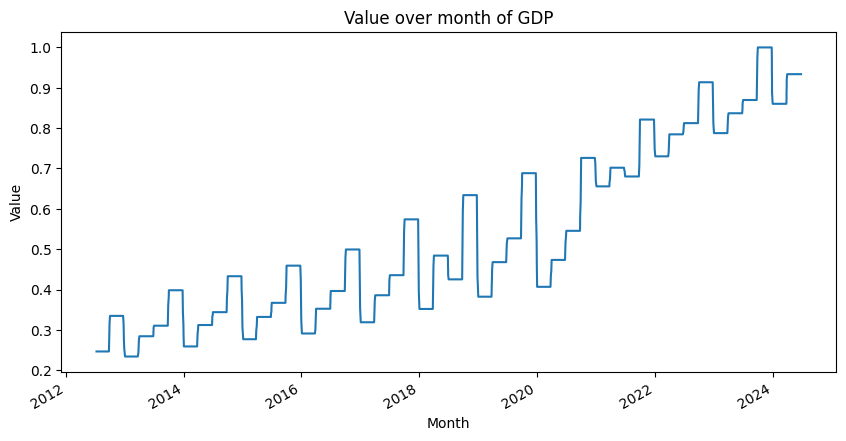

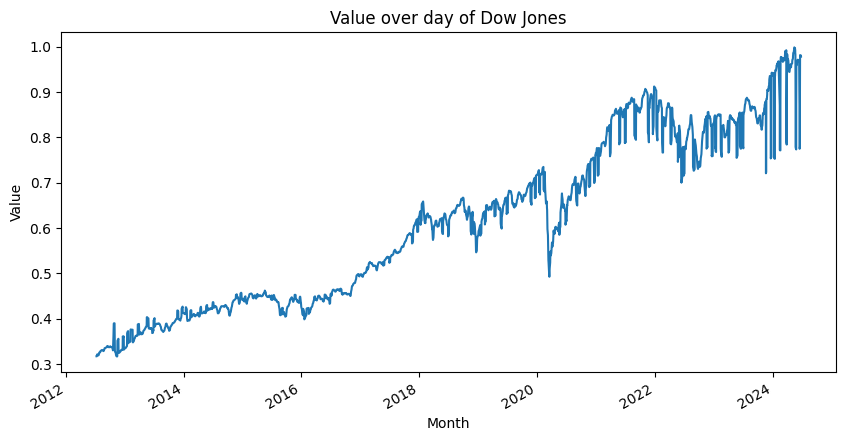

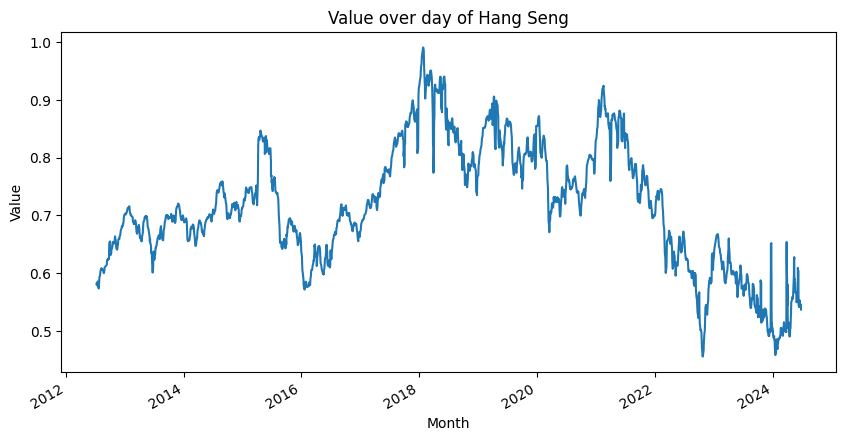

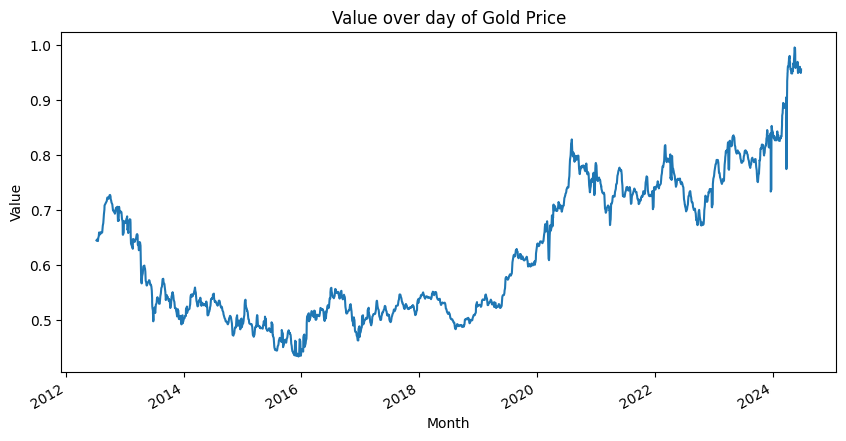

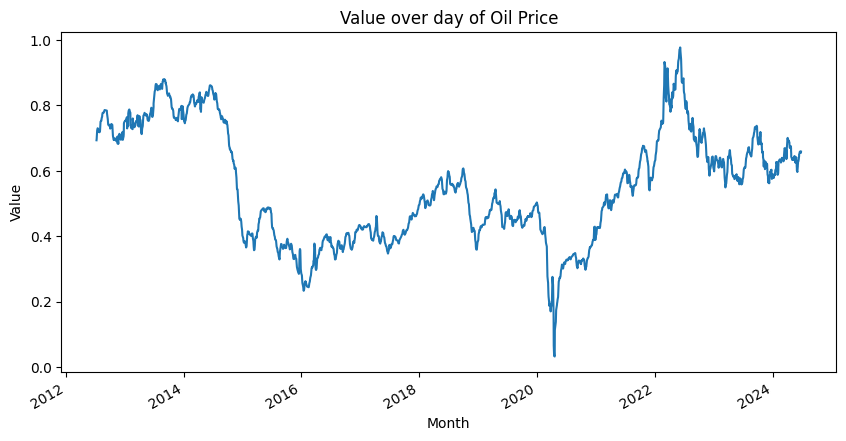

In [ ]:
plt.figure(figsize=(10, 5))
df['Volume'].plot()
plt.title('Volume over day of Index')
plt.xlabel('Date')
plt.ylabel('Volume')

plt.figure(figsize=(10, 5))
df['CPI'].plot()
plt.title('Value over month of CPI Index')
plt.xlabel('Month')
plt.ylabel('Value')

plt.figure(figsize=(10, 5))
df['Interest'].plot()
plt.title('Value over day of Prime Rate')
plt.xlabel('Date')
plt.ylabel('Value')

plt.figure(figsize=(10, 5))
df['Exchange Rate'].plot()
plt.title('Value over day of Exchange Rate (USD - VND)')
plt.xlabel('Date')
plt.ylabel('Value')

plt.figure(figsize=(10, 5))
df['GDP'].plot()
plt.title('Value over month of GDP')
plt.xlabel('Month')
plt.ylabel('Value')

plt.figure(figsize=(10, 5))
df['Dow Jones'].plot()
plt.title('Value over day of Dow Jones')
plt.xlabel('Month')
plt.ylabel('Value')

plt.figure(figsize=(10, 5))
df['Hang Seng'].plot()
plt.title('Value over day of Hang Seng')
plt.xlabel('Month')
plt.ylabel('Value')

plt.figure(figsize=(10, 5))
df['Gold Price'].plot()
plt.title('Value over day of Gold Price')
plt.xlabel('Month')
plt.ylabel('Value')

plt.figure(figsize=(10, 5))
df['Oil Price'].plot()
plt.title('Value over day of Oil Price')
plt.xlabel('Month')
plt.ylabel('Value')

plt.show()

## **3. Chuẩn bị dữ liệu**

In [ ]:
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset, label_name):
    features = []
    labels = []

    if df_end_idx == None:
        df_end_idx = len(df) - label_size - offset

    df_start_idx = df_start_idx + input_size + offset

    for idx in range(df_start_idx, df_end_idx):
        feature_start_idx = idx - input_size - offset
        feature_end_idx = feature_start_idx + input_size

        label_start_idx = idx - 1
        label_end_idx = label_start_idx + label_size

        feature = df[feature_start_idx:feature_end_idx]
        label = df[label_name][label_start_idx:label_end_idx]

        features.append(feature)
        labels.append(label)

    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [ ]:
def slicing_window_flatten(df, df_start_idx, df_end_idx, input_size, label_size, offset, label_name):
    features = []
    labels = []

    if df_end_idx == None:
        df_end_idx = len(df) - label_size - offset

    df_start_idx = df_start_idx + input_size + offset

    for idx in range(df_start_idx, df_end_idx):
        feature_start_idx = idx - input_size - offset
        feature_end_idx = feature_start_idx + input_size

        label_start_idx = idx - 1
        label_end_idx = label_start_idx + label_size

        feature = df[df.columns[df.columns != label_name]][feature_start_idx:feature_end_idx].to_numpy().flatten()
        label = df[label_name][label_start_idx:label_end_idx]

        features.append(feature)
        labels.append(label)

    features = np.array(features)
    labels = np.array(labels)

    return features, labels

In [ ]:
INPUT_SIZE = 15
LABEL_SIZE = 1
OFFSET = 1
BATCH_SIZE = 256
TARGET_NAME = 'Last'

In [ ]:
dataset_length = len(df)
TRAIN_SIZE = 0.7
VAL_SIZE = 0.2

TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length)
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

X_train_1, y_train_1 = slicing_window(df,
                                  df_start_idx=0,
                                  df_end_idx=TRAIN_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

X_val_1, y_val_1 = slicing_window(df,
                                  df_start_idx=TRAIN_END_IDX,
                                  df_end_idx=VAL_END_IDX,
                                  input_size=INPUT_SIZE,
                                  label_size=LABEL_SIZE,
                                  offset=OFFSET,
                                  label_name=TARGET_NAME)

X_test_1, y_test_1 = slicing_window(df,
                                    df_start_idx=VAL_END_IDX,
                                    df_end_idx=None,
                                    input_size=INPUT_SIZE,
                                    label_size=LABEL_SIZE,
                                    offset=OFFSET,
                                    label_name=TARGET_NAME)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_1, y_train_1)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_1, y_val_1)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_1, y_test_1)).batch(BATCH_SIZE)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
dataset_length = len(df)
TRAIN_SIZE = 0.7
VAL_SIZE = 0.2

TRAIN_END_IDX = int(TRAIN_SIZE * dataset_length)
VAL_END_IDX = int(VAL_SIZE * dataset_length) + TRAIN_END_IDX

X_train, y_train = slicing_window_flatten(df,
                                          df_start_idx=0,
                                          df_end_idx=TRAIN_END_IDX,
                                          input_size=INPUT_SIZE,
                                          label_size=LABEL_SIZE,
                                          offset=OFFSET,
                                          label_name=TARGET_NAME)

X_val, y_val = slicing_window_flatten(df,
                                      df_start_idx=TRAIN_END_IDX,
                                      df_end_idx=VAL_END_IDX,
                                      input_size=INPUT_SIZE,
                                      label_size=LABEL_SIZE,
                                      offset=OFFSET,
                                      label_name=TARGET_NAME)

X_test, y_test = slicing_window_flatten(df,
                                        df_start_idx=VAL_END_IDX,
                                        df_end_idx=None,
                                        input_size=INPUT_SIZE,
                                        label_size=LABEL_SIZE,
                                        offset=OFFSET,
                                        label_name=TARGET_NAME)

In [ ]:
X, y = slicing_window_flatten(df,
                              df_start_idx=0,
                              df_end_idx=dataset_length,
                              input_size=INPUT_SIZE,
                              label_size=LABEL_SIZE,
                              offset=OFFSET,
                              label_name=TARGET_NAME)

## **4. Mô hình XGBoost**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []
adjusted_r2_scores = []

for train_index, test_index in tscv.split(X):
    x_train_split, x_test_split = X[train_index], X[test_index]
    y_train_split, y_test_split = y[train_index], y[test_index]

    xgboost = XGBRegressor()
    xgboost.fit(x_train_split, y_train_split)

    predictions = xgboost.predict(x_test_split)
    mae = mean_absolute_error(y_test_split, predictions)
    mae_scores.append(mae)
    mse = mean_squared_error(y_test_split, predictions)
    mse_scores.append(mse)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
    mape = mean_absolute_percentage_error(y_test_split, predictions)
    mape_scores.append(mape)

print("Cross-Validation MAE Scores:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))
print("Cross-Validation MSE Scores:", mse_scores)
print("Mean MSE:", np.mean(mse_scores))
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Cross-Validation MAPE Scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))

Cross-Validation MAE Scores: [0.18853019119473416, 0.21113738027107823, 0.17094702381108107, 0.023830381990315466, 0.03719004536729494]
Mean MAE: 0.1263270045269008
Cross-Validation MSE Scores: [0.055276090303702834, 0.0520344557708198, 0.033278860815754034, 0.0011275448530904736, 0.0018092143820752557]
Mean MSE: 0.02870523322508848
Cross-Validation RMSE Scores: [0.23510867764440946, 0.22811062178429964, 0.18242494570577247, 0.033578934662828026, 0.042534860785892505]
Mean RMSE: 0.14435160811664044
Cross-Validation MAPE Scores: [0.28520901094094414, 0.9456327211541643, 0.7952088166014146, 0.14067502183097144, 0.28092726436673926]
Mean MAPE: 0.4895305669788468


In [ ]:
y_test_pred = xgboost.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_test_pred)}')

MAE: 0.04894563507106157
MSE: 0.002628818311334404
RMSE: 0.051272003192136
MAPE: 0.3879354586853035


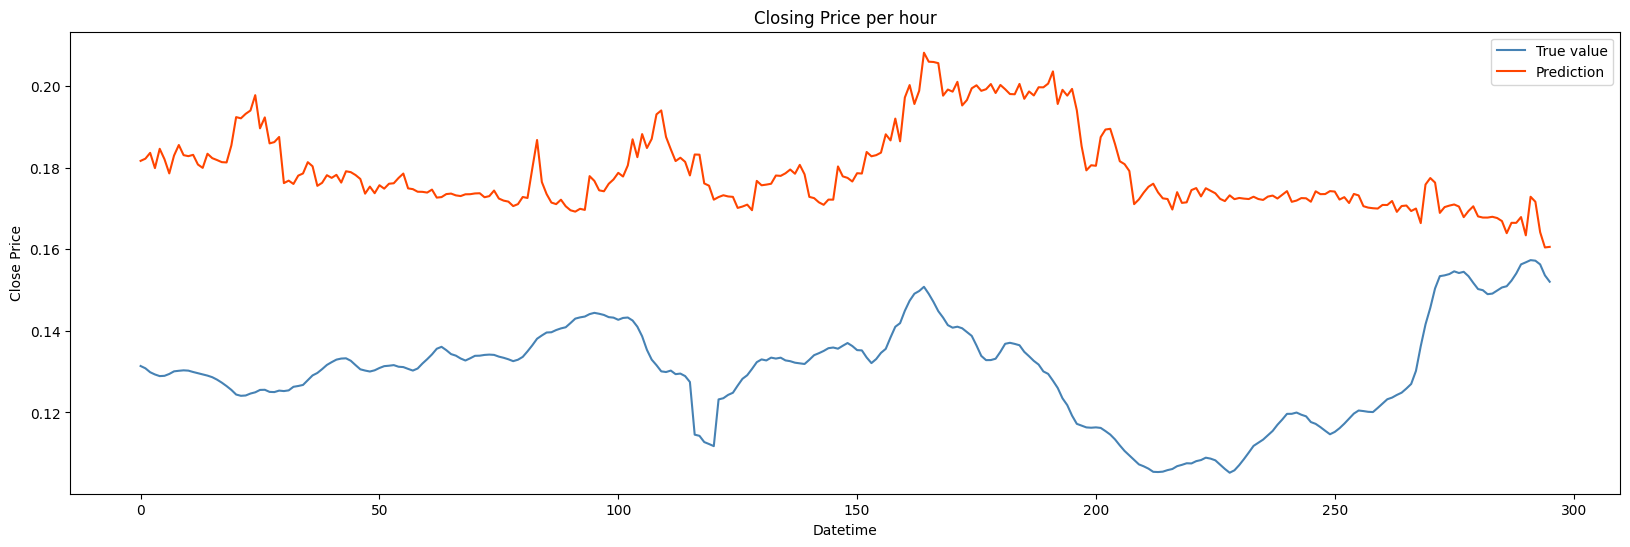

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', label='Prediction')

    plt.title('Closing Price per hour')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test, xgboost.predict(X_test))

## **5. Mô hình Linear Regression**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []
adjusted_r2_scores = []

for train_index, test_index in tscv.split(X):
    x_train_split, x_test_split = X[train_index], X[test_index]
    y_train_split, y_test_split = y[train_index], y[test_index]

    linear = LinearRegression()
    linear.fit(x_train_split, y_train_split)

    predictions = linear.predict(x_test_split)
    mae = mean_absolute_error(y_test_split, predictions)
    mae_scores.append(mae)
    mse = mean_squared_error(y_test_split, predictions)
    mse_scores.append(mse)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
    mape = mean_absolute_percentage_error(y_test_split, predictions)
    mape_scores.append(mape)

print("Cross-Validation MAE Scores:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))
print("Cross-Validation MSE Scores:", mse_scores)
print("Mean MSE:", np.mean(mse_scores))
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Cross-Validation MAPE Scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))

Cross-Validation MAE Scores: [0.15136247892041996, 0.08848172910818926, 0.09048686558313844, 0.07497222400766645, 0.18203066003753515]
Mean MAE: 0.11746679153138986
Cross-Validation MSE Scores: [0.04134440741809627, 0.012409131583398196, 0.011686602238395469, 0.008313551305865781, 0.03544397165266176]
Mean MSE: 0.021839532839683495
Cross-Validation RMSE Scores: [0.2033332422849158, 0.11139628173057751, 0.10810458934936791, 0.0911786779124691, 0.18826569430637585]
Mean RMSE: 0.14045569711674125
Cross-Validation MAPE Scores: [0.21251033495289134, 0.39392641224776087, 0.44601164267103033, 0.42110500007217117, 1.2753136552081055]
Mean MAPE: 0.5497734090303918


In [ ]:
y_test_pred = linear.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_test_pred)}')

MAE: 0.18879098880314377
MSE: 0.03793981209729643
RMSE: 0.19478144700483266
MAPE: 1.4529865340972117


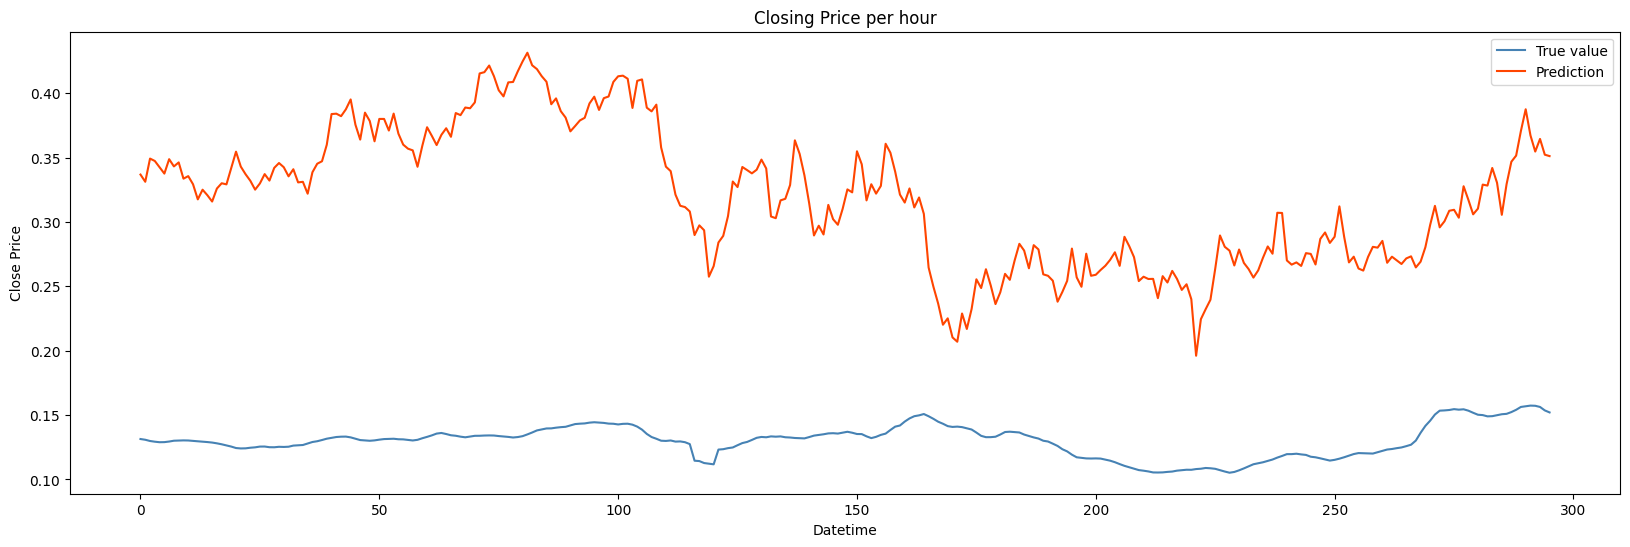

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', label='Prediction')

    plt.title('Closing Price per hour')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test, linear.predict(X_test))

## **6. Mô hình Ridge Regression**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []
mse_scores = []
rmse_scores = []
mape_scores = []
r2_scores = []
adjusted_r2_scores = []

for train_index, test_index in tscv.split(X):
    x_train_split, x_test_split = X[train_index], X[test_index]
    y_train_split, y_test_split = y[train_index], y[test_index]

    ridge = Ridge(alpha=1.0)
    ridge.fit(x_train_split, y_train_split)

    predictions = ridge.predict(x_test_split)
    mae = mean_absolute_error(y_test_split, predictions)
    mae_scores.append(mae)
    mse = mean_squared_error(y_test_split, predictions)
    mse_scores.append(mse)
    rmse = np.sqrt(mse)
    rmse_scores.append(rmse)
    mape = mean_absolute_percentage_error(y_test_split, predictions)
    mape_scores.append(mape)

print("Cross-Validation MAE Scores:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))
print("Cross-Validation MSE Scores:", mse_scores)
print("Mean MSE:", np.mean(mse_scores))
print("Cross-Validation RMSE Scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Cross-Validation MAPE Scores:", mape_scores)
print("Mean MAPE:", np.mean(mape_scores))

Cross-Validation MAE Scores: [0.17298948913165277, 0.09819111810592687, 0.08640027350525309, 0.08557859199290085, 0.17366608643580217]
Mean MAE: 0.12336511183430714
Cross-Validation MSE Scores: [0.046920470821374294, 0.014164997235813149, 0.010880458837308774, 0.009957901903690398, 0.032100178298315296]
Mean MSE: 0.02280480141930038
Cross-Validation RMSE Scores: [0.2166113358561234, 0.11901679392343396, 0.10430943791100004, 0.09978928751970523, 0.17916522625307427]
Mean RMSE: 0.14377841629266738
Cross-Validation MAPE Scores: [0.2557134598233959, 0.44079905075066556, 0.4300188549721742, 0.4856556431932936, 1.209418747076489]
Mean MAPE: 0.5643211511632036


In [ ]:
y_test_pred = ridge.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_test_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_test_pred)}')

MAE: 0.17598544408778602
MSE: 0.03347205915382135
RMSE: 0.1829537076798974
MAPE: 1.3527367612284529


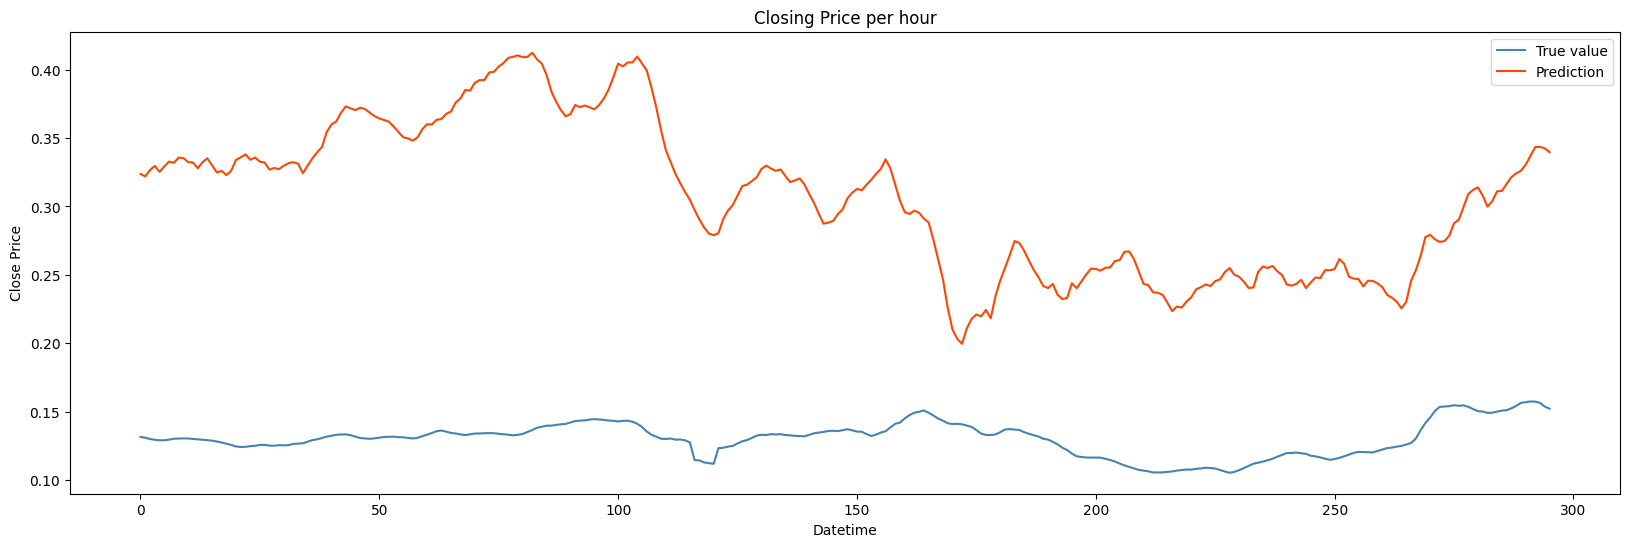

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', label='Prediction')

    plt.title('Closing Price per hour')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test, ridge.predict(X_test))

## **7. Mô hình BiLSTM**

### **7.1. Xây dựng mô hình**

In [ ]:
# Khai báo normalization layer
normalize_layer = tf.keras.layers.Normalization(name='input_normalizer')
normalize_layer.adapt(np.vstack((X_train_1, X_val_1, X_test_1)))

In [ ]:
def build_model(input_shape, output_size):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.Input(shape=input_shape, name='input_layer'),

        normalize_layer,

        # BiLSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                      return_sequences=True,
                                      kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_3'),

        # Dropout Layer 2
        tf.keras.layers.Dropout(0.05, name='dropout_layer_3'),

        # BiLSTM Layer 1
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,
                                      return_sequences=True,
                                      kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_1'),

        # Dropout Layer 1
        tf.keras.layers.Dropout(0.1, name='dropout_layer_1'),

        # BiLSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                      return_sequences=True,
                                      kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_2'),

        # Dropout Layer 2
        tf.keras.layers.Dropout(0.1, name='dropout_layer_2'),

        # BiLSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16,
                                      return_sequences=True,
                                      kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_5'),

        # Dropout Layer 2
        tf.keras.layers.Dropout(0.05, name='dropout_layer_5'),

        # Flatten Layer
        tf.keras.layers.Flatten(name='flatten_layer'),

        # FC Layer 1
        tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='fc_layer_1'),

        # Output Layer
        tf.keras.layers.Dense(output_size,
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='output_layer')
    ],
    name='bilstm_model')

    return model

In [ ]:
INPUT_SHAPE = X_train_1.shape[-2:]
model = build_model(INPUT_SHAPE,
                    LABEL_SIZE)
model.summary()

Model: "bilstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_normalizer (Normalization)     │ (None, 15, 13)              │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bilstm_layer_3 (Bidirectional)       │ (None, 15, 64)              │          11,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_3 (Dropout)            │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bilstm_layer_1 (Bidirectional)       │ (None, 15, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_1 (Dropout)            │ (None, 15, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bilstm_layer_2 (Bidirectional)       │ (None, 15, 64)              │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_2 (Dropout)            │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bilstm_layer_5 (Bidirectional)       │ (None, 15, 32)              │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_layer_5 (Dropout)            │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_layer_1 (Dense)                   │ (None, 32)                  │          15,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,860 (565.86 KB)

 Trainable params: 144,833 (565.75 KB)

 Non-trainable params: 27 (112.00 B)

### **7.2. Cấu hình mô hình**

In [ ]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 500
LR = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), # Sử dụng optimizer Adam
    loss=tf.keras.losses.MeanAbsoluteError(), # Sử dụng hàm loss Mean Absolute Error
)

### **7.3. Huấn luyện mô hình**

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.2025 - val_loss: 0.1414
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.3155 - val_loss: 0.1301
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4247 - val_loss: 0.0640
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1474 - val_loss: 0.0702
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1646 - val_loss: 0.0712
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1483 - val_loss: 0.0462
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2126 - val_loss: 0.0478
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0908 - val_loss: 0.0708
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2384 - val_loss: 0.0617
Epoch 10/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0930 - val_loss: 0.0483
Epoch 11/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1853 - val_loss: 0.0371
Epoch 12/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1777 - val_l

### **7.4. Đánh giá mô hình và trực quan hóa**

In [ ]:
y_test_pred = model.predict(X_test_1, verbose=0)
print(f'MAE: {mean_absolute_error(y_test_1, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test_1, y_test_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_1, y_test_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test_1, y_test_pred)}')

MAE: 0.16743366074641314
MSE: 0.029212253600784395
RMSE: 0.1709159255329485
MAPE: 1.3107476222187535


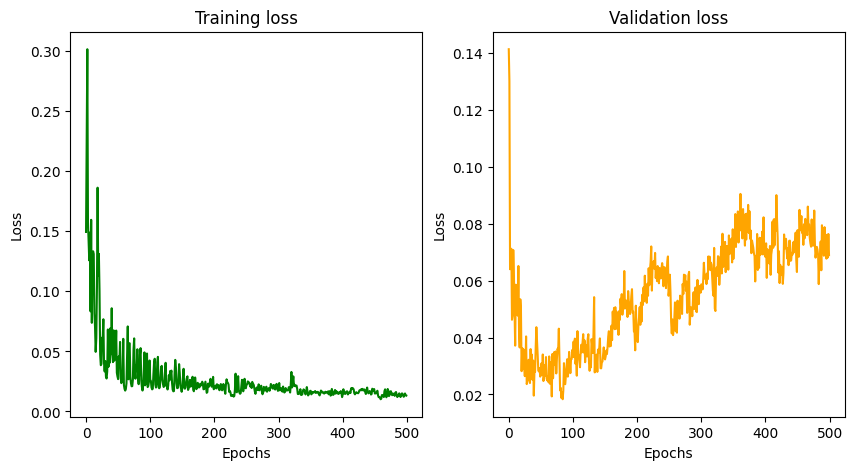

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.plot(train_loss, color='green')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.plot(val_loss, color='orange')

plt.show()

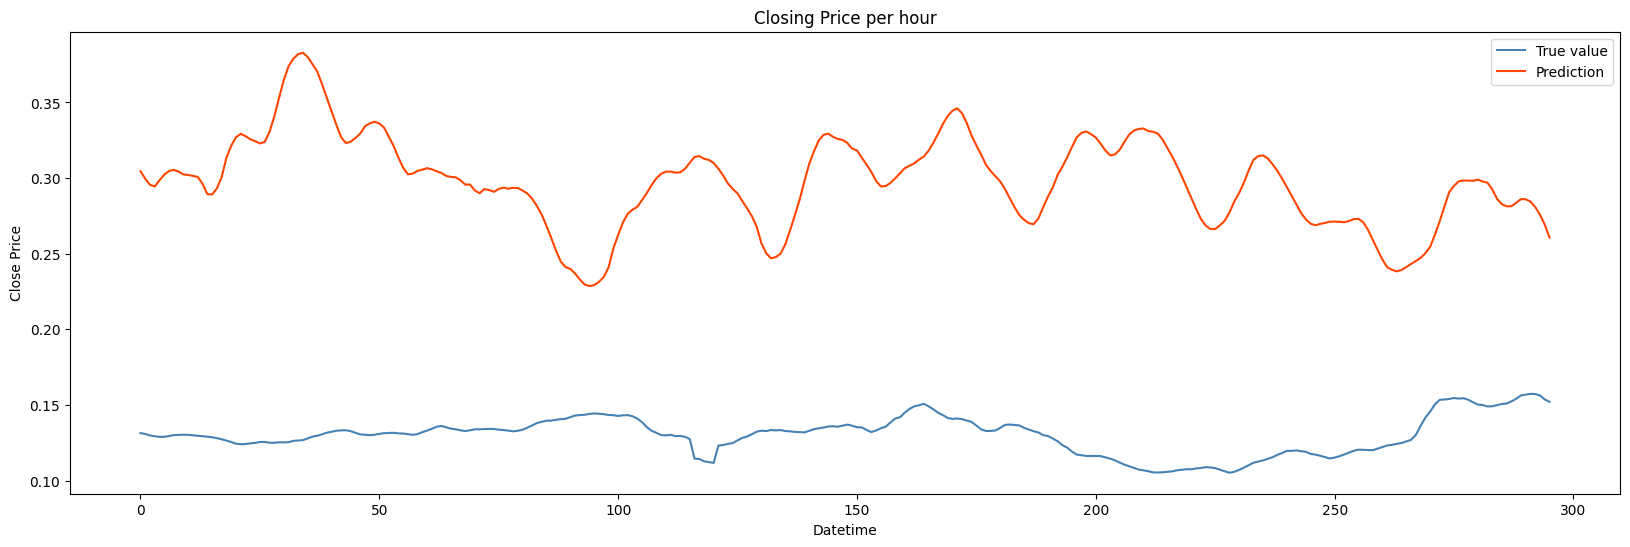

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', label='Prediction')

    plt.title('Closing Price per hour')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test_1, model.predict(X_test_1, verbose=0))

## **8. Mô hình RNN**

### **8.1. Xây dựng mô hình**

In [ ]:
# Khai báo normalization layer
normalize_layer = tf.keras.layers.Normalization(name='input_normalizer')
normalize_layer.adapt(np.vstack((X_train_1, X_val_1, X_test_1)))

In [ ]:
# Xây dựng hàm khởi tạo model
def build_model(input_shape, output_size):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.Input(shape=input_shape, name='input_layer'),

        normalize_layer,

        # BiLSTM Layer 1
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(128,
                                                           return_sequences=True,
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_1'),

        # BiLSTM Layer 2
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(64,
                                                           return_sequences=True,
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_2'),

        # BiLSTM Layer 3
        tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32,
                                                           return_sequences=False,
                                                           kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED)),
                                      name='bilstm_layer_3'),

        # FC Layer 1
        tf.keras.layers.Dense(32,
                              activation='relu',
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='fc_layer_1'
                              ),

        # Output Layer
        tf.keras.layers.Dense(output_size,
                              kernel_initializer=tf.initializers.GlorotUniform(seed=RANDOM_SEED),
                              name='output_layer')
    ],
    name='bilstm_model')

    return model

In [ ]:
INPUT_SHAPE = X_train_1.shape[-2:]
model = build_model(INPUT_SHAPE,
                    LABEL_SIZE)
model.summary()

Model: "bilstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_normalizer (Normalization)     │ (None, 15, 13)              │              27 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bilstm_layer_1 (Bidirectional)       │ (None, 15, 256)             │          36,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bilstm_layer_2 (Bidirectional)       │ (None, 15, 128)             │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bilstm_layer_3 (Bidirectional)       │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_layer_1 (Dense)                   │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,884 (351.11 KB)

 Trainable params: 89,857 (351.00 KB)

 Non-trainable params: 27 (112.00 B)

### **8.2. Cấu hình mô hình**

In [ ]:
# Khai báo một số giá trị siêu tham số
EPOCHS = 500
LR = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR), # Sử dụng optimizer Adam
    loss=tf.keras.losses.MeanAbsoluteError(), # Sử dụng hàm loss Mean Absolute Error
)

### **8.3. Huấn luyện mô hình**

In [ ]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS)

Epoch 1/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - loss: 0.5197 - val_loss: 0.9773
Epoch 2/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.5690 - val_loss: 1.0172
Epoch 3/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3966 - val_loss: 0.6029
Epoch 4/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2964 - val_loss: 0.6429
Epoch 5/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3247 - val_loss: 0.1925
Epoch 6/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3141 - val_loss: 0.3639
Epoch 7/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4799 - val_loss: 0.5553
Epoch 8/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1458 - val_loss: 0.4286
Epoch 9/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2975 - val_loss: 0.9870
Epoch 10/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3062 - val_loss: 0.4195
Epoch 11/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2679 - val_loss: 0.3718
Epoch 12/500
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2692 - val_

### **8.4. Đánh giá mô hình và trực quan hóa**

In [ ]:
y_test_pred = model.predict(X_test_1, verbose=0)
print(f'MAE: {mean_absolute_error(y_test_1, y_test_pred)}')
print(f'MSE: {mean_squared_error(y_test_1, y_test_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test_1, y_test_pred))}')
print(f'MAPE: {mean_absolute_percentage_error(y_test_1, y_test_pred)}')

MAE: 1.13379882917129
MSE: 1.3303900083486717
RMSE: 1.1534253371365968
MAPE: 8.841130949616838


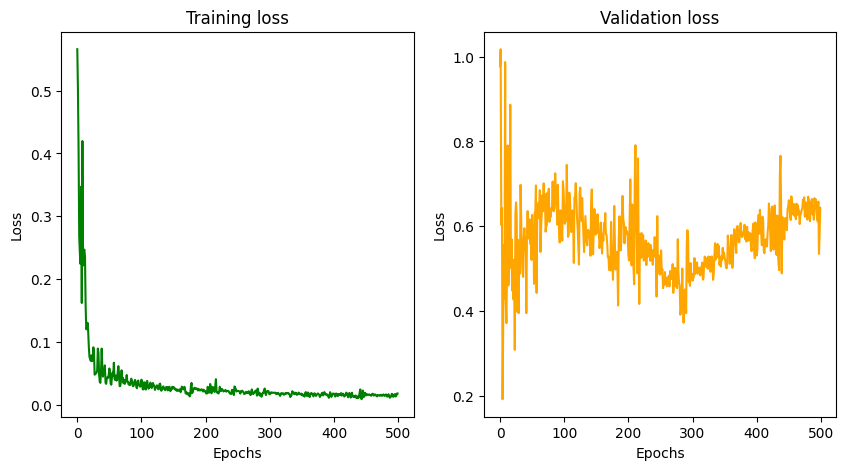

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.plot(train_loss, color='green')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation loss')
plt.plot(val_loss, color='orange')

plt.show()

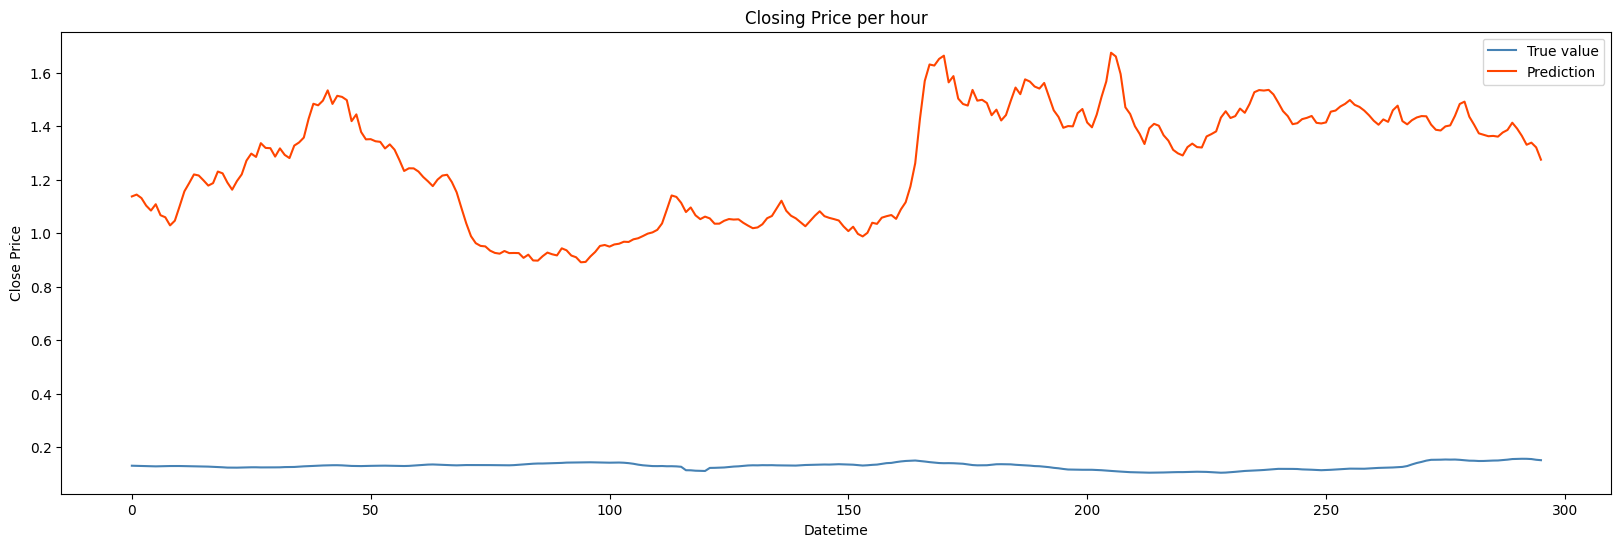

In [ ]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()

    plt.plot(times, y_to_plot, color='steelblue', label='True value')
    plt.plot(times, pred_to_plot, color='orangered', label='Prediction')

    plt.title('Closing Price per hour')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

plot_difference(y_test_1, model.predict(X_test_1, verbose=0))